# Machine Learning for Computer Vision
Martin Huber and Lucas-Raphael Müller

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os, os.path
from scipy import misc, ndimage
from skimage.morphology import disk
from skimage import filters
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from PIL import Image
from itertools import chain
from collections import OrderedDict
%matplotlib inline

In [2]:
# import data - part (a)

class Picture:
    def __init__(self, rgbFilepath, groundFilepath):
        self.rgbFilepath = rgbFilepath
        self.groundFilepath = groundFilepath
        rgbImage= ndimage.imread(rgbFilepath)
        groundImage = ndimage.imread(groundFilepath)
        
        # downscale
        resizedSize = min(rgbImage.shape,groundImage.shape);
        self.rgbImage = misc.imresize(rgbImage, resizedSize)        
        self.groundImage = misc.imresize(groundImage, resizedSize[0:2])
        
        self.feature = OrderedDict()
        
    def computeFeature(self):      
        self.feature['gaussed'] = np.ndarray(self.rgbImage.shape)
        self.feature['laplaced'] = np.ndarray(self.rgbImage.shape)
        self.feature['medianed'] = np.ndarray(self.rgbImage.shape)
        
        for i in range(self.rgbImage.shape[2]):
                self.feature['gaussed'][:,:,i] = filters.gaussian((self.rgbImage[:,:,i]), sigma = 1)
                self.feature['laplaced'][:,:,i] = filters.laplace((self.rgbImage[:,:,i]))
                self.feature['medianed'][:,:,i] = filters.median((self.rgbImage[:,:,i]), disk(5))                
        

def readFromDirectory(directory):
    files = []
    validExtensions = ['.jpeg', '.jpg']
    for currentFile in os.listdir(os.path.join(directory, 'rgb')):
        if not os.path.splitext(currentFile)[1] in validExtensions:
            print('skipped')
            continue
        files.append(Picture(
            os.path.join(directory, 'rgb', currentFile),
            os.path.join(directory, 'figure_ground', currentFile)
        ))
    return files

allPictures = readFromDirectory('pictureData')
# select first few for training
trainPictures = allPictures[0:10]
# select other 10 for testing purpose
testPictures = [allPictures[i] for i in [13,14,15,17,19,20,21,22,26,27]]

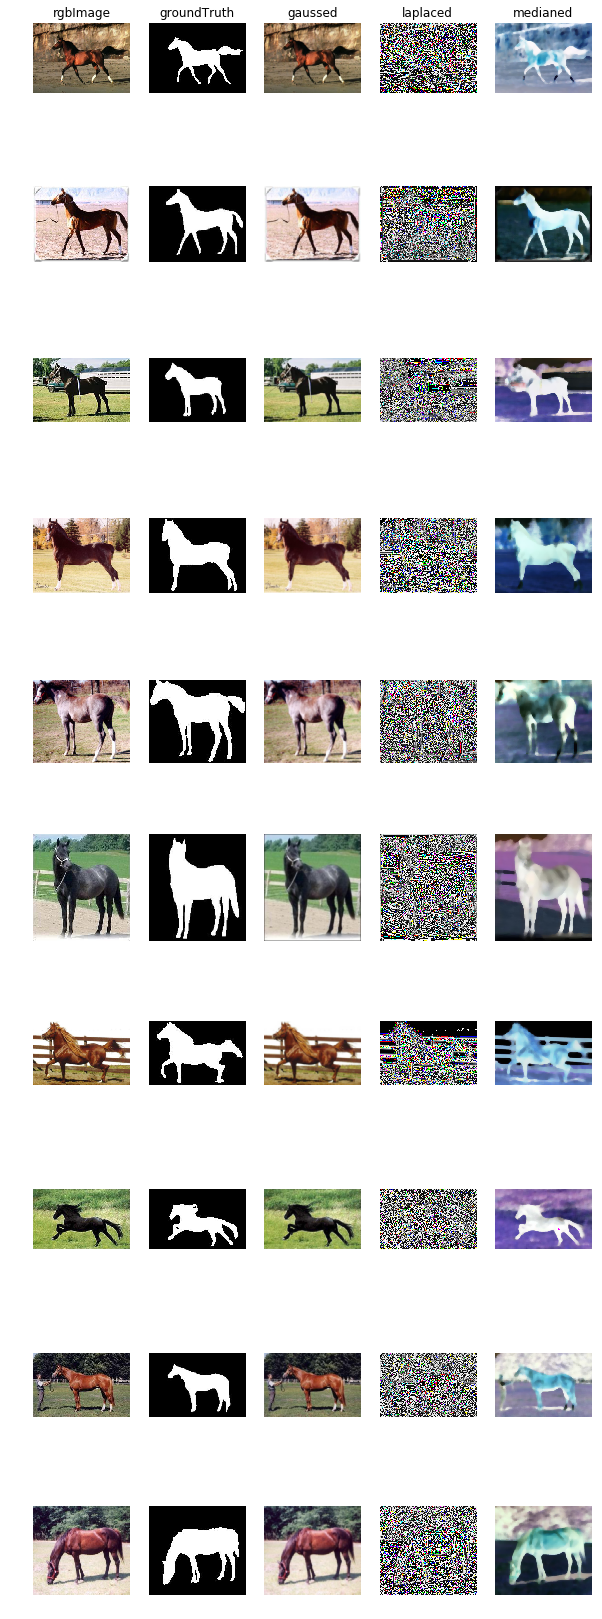

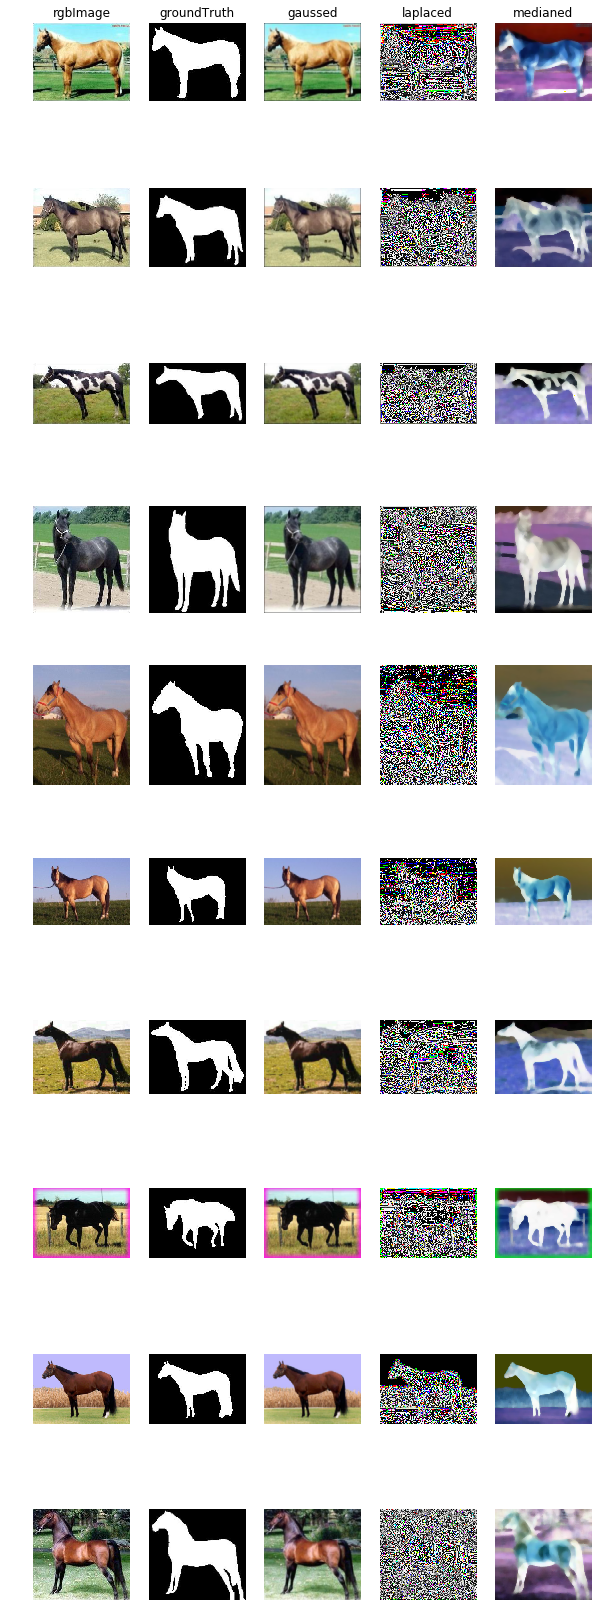

In [3]:
# compute features
# apply them on the objects of class Pictures

for i in trainPictures:
    i.computeFeature()
    
for i in testPictures:
    i.computeFeature()
    
def plotFeatures(pictures):
    f, axArr = plt.subplots(len(pictures),len(pictures[0].feature.items()) + 2, figsize = (10, 30))
    for i in range(len(pictures)):
        axArr[i, 0].imshow(pictures[i].rgbImage)
        axArr[i, 1].imshow(pictures[i].groundImage, cmap = 'gray')
        
        if i == 0:
            axArr[i, 0].set_title('rgbImage')
            axArr[i, 1].set_title('groundTruth')
            for j, currEl in enumerate(pictures[i].feature.items()):
                axArr[i, j + 2].set_title(currEl[0])
            
        for j, currEl in enumerate(pictures[i].feature.items()):
            axArr[i,j + 2].imshow(currEl[1])
            
        for j in range(len(pictures[0].feature.items()) + 2):
            axArr[i,j].axis('off')
        
    plt.show()
    
plotFeatures(trainPictures)
plotFeatures(testPictures)

In [44]:
# random forest classifier (c)
# create X matrix [n_samples, n_features]
# rgb + gauss, laplace, median

nSamples = sum([currImage.rgbImage.shape[0] * currImage.rgbImage.shape[1] for currImage in trainPictures])
nFeatures = 3 * (len(trainPictures[0].feature) + 1)

X = np.ndarray([nSamples, nFeatures])

# put in original rgb data
def prepareInputData(Pictures):
    for i in range(3):
        X[:, i] = np.concatenate([np.reshape(currImage.rgbImage[:,:,i], currImage.rgbImage.shape[0] * \
                                             currImage.rgbImage.shape[1]) for currImage in Pictures])
        # for now hard coded (time pressure :O)
        X[:, i + 3] = np.concatenate([np.reshape(currImage.feature['gaussed'][:,:,i], currImage.rgbImage.shape[0] * \
                                                 currImage.rgbImage.shape[1]) for currImage in Pictures])
        X[:, i + 6] = np.concatenate([np.reshape(currImage.feature['laplaced'][:,:,i], currImage.rgbImage.shape[0] * \
                                                 currImage.rgbImage.shape[1]) for currImage in Pictures])
        X[:, i + 9] = np.concatenate([np.reshape(currImage.feature['medianed'][:,:,i], currImage.rgbImage.shape[0] * \
                                                 currImage.rgbImage.shape[1]) for currImage in Pictures])
    return X

X = prepareInputData(trainPictures)
# Y matrix holding target values [n_samples]
Y = np.ndarray([nSamples])
Y = np.concatenate([np.reshape(currImage.groundImage[:,:], currImage.rgbImage.shape[0] * currImage.rgbImage.shape[1]) for currImage in trainPictures])

In [39]:
clf = RandomForestClassifier(n_estimators = 25)
clf = clf.fit(X, Y)

In [42]:
# throw test images on it
for i, currImage in enumerate(testPictures):
    testX = np.ndarray([currImage.rgbImage.shape[0] * currImage.rgbImage.shape[1], nFeatures])
    for j in range(3):
        testX[:, j] = np.reshape(currImage.rgbImage[:,:,j], currImage.rgbImage.shape[0] * currImage.rgbImage.shape[1])
        # for now hard coded (time pressure :O)
        testX[:, j + 3] = np.reshape(currImage.feature['gaussed'][:,:,j], currImage.rgbImage.shape[0] * currImage.rgbImage.shape[1])
        testX[:, j + 6] = np.reshape(currImage.feature['laplaced'][:,:,j], currImage.rgbImage.shape[0] * currImage.rgbImage.shape[1])
        testX[:, j + 9] = np.reshape(currImage.feature['medianed'][:,:,j], currImage.rgbImage.shape[0] * currImage.rgbImage.shape[1])
    currImage.rfcOutcome = np.reshape(clf.predict(testX), currImage.groundImage.shape)

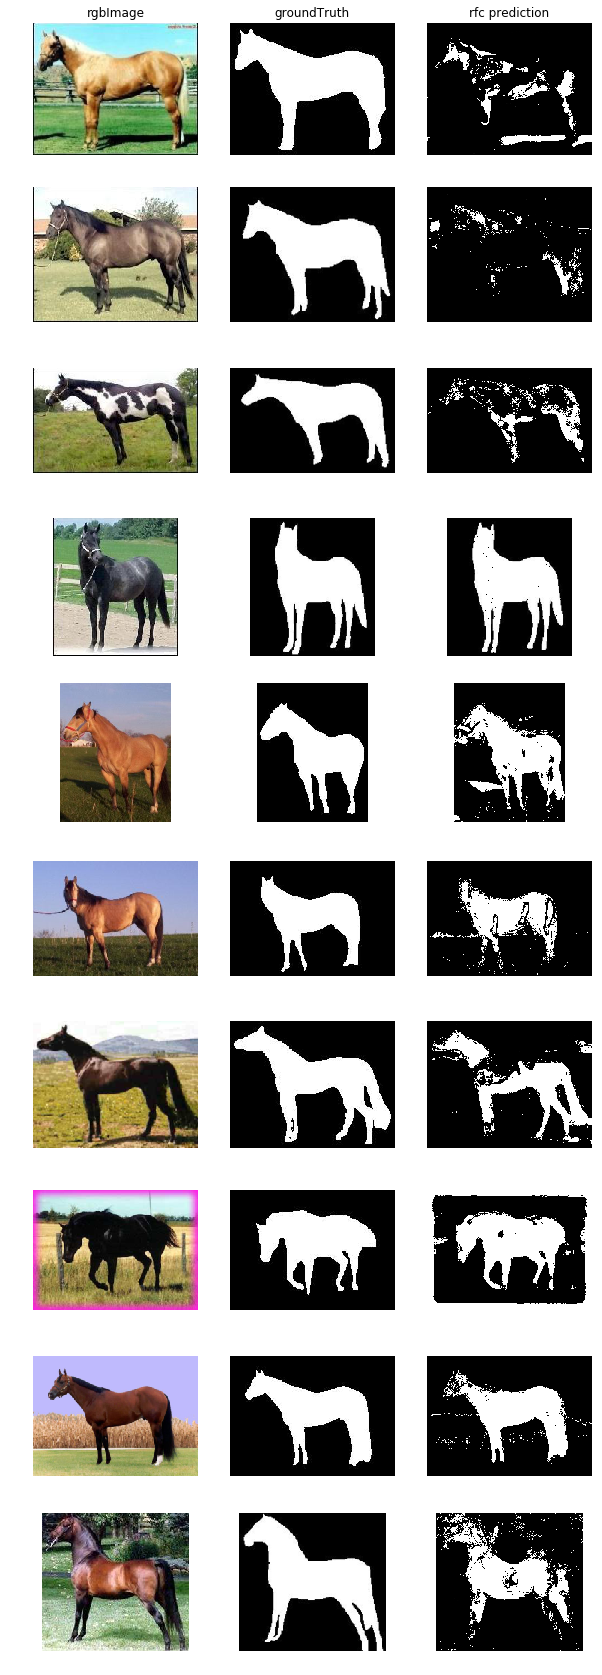

In [43]:
# plot outcome
def plotRfcOutcome(pictures):
    f, axArr = plt.subplots(len(pictures),3, figsize = (10, 30))
    for i in range(len(pictures)):
        axArr[i, 0].imshow(pictures[i].rgbImage)
        axArr[i, 1].imshow(pictures[i].groundImage, cmap = 'gray')
        axArr[i, 2].imshow(pictures[i].rfcOutcome, cmap = 'gray')
        
        if i == 0:
            axArr[i, 0].set_title('rgbImage')
            axArr[i, 1].set_title('groundTruth')
            axArr[i, 2].set_title('rfc prediction')
            
            
        for j in range(3):
            axArr[i,j].axis('off')
        
    plt.show()
plotRfcOutcome(testPictures)   